<a href="https://colab.research.google.com/github/Jashkine/Finetune_llm/blob/main/finetune_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade fsspec datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# ✅ Load pretrained GPT-2 and tokenizer
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# GPT-2 does not have a padding token by default
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Embedding(50257, 768)

In [10]:
# ✅ Load a public dataset — we’ll use wikitext
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

def tokenize_function(examples):
    result = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])


Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [11]:
# ✅ Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-wikitext-results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    save_steps=500,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,  # Use mixed precision if on GPU
)

# ✅ Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [12]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [13]:

# ✅ Start training
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,1.866600
200,1.386200
300,1.262900
400,1.405900
500,1.339200
600,1.415200
700,1.366000
800,1.388500
900,1.256600
1000,1.264000


TrainOutput(global_step=9180, training_loss=1.2791982372342112, metrics={'train_runtime': 1319.7645, 'train_samples_per_second': 27.822, 'train_steps_per_second': 6.956, 'total_flos': 2398530207744000.0, 'train_loss': 1.2791982372342112, 'epoch': 1.0})

In [22]:
# Save the model and tokenizer to a directory
save_directory = "./gpt2-finetuned"

trainer.save_model(save_directory)          # Saves model and config
tokenizer.save_pretrained(save_directory)  # Saves tokenizer files too


('./gpt2-finetuned/tokenizer_config.json',
 './gpt2-finetuned/special_tokens_map.json',
 './gpt2-finetuned/vocab.json',
 './gpt2-finetuned/merges.txt',
 './gpt2-finetuned/added_tokens.json',
 './gpt2-finetuned/tokenizer.json')

In [14]:
results = trainer.evaluate(eval_dataset=tokenized_dataset["validation"])
print(results)

{'eval_loss': 1.2805769443511963, 'eval_runtime': 21.4797, 'eval_samples_per_second': 175.049, 'eval_steps_per_second': 21.881, 'epoch': 1.0}


In [15]:
import math

eval_loss = results["eval_loss"]
perplexity = math.exp(eval_loss)
print(f"Perplexity: {perplexity:.2f}")


Perplexity: 3.60


In [16]:
test_results = trainer.evaluate(eval_dataset=tokenized_dataset["test"])
test_perplexity = math.exp(test_results["eval_loss"])
print(f"Test Perplexity: {test_perplexity:.2f}")


Test Perplexity: 3.47


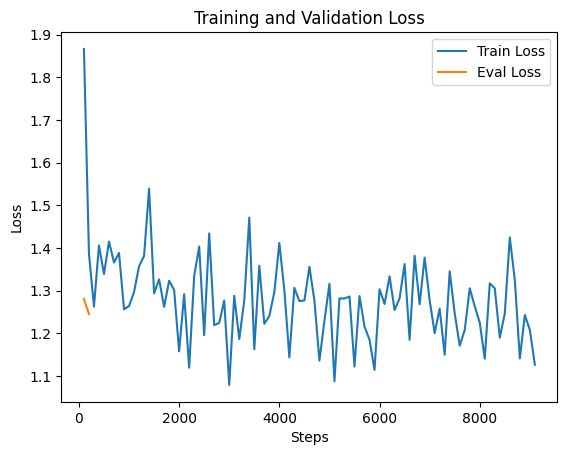

In [18]:
import matplotlib.pyplot as plt
import json

# Path to your training log file (adjust if different)
log_path = "./logs/events.out.tfevents..."

# If using tensorboard logs, you can convert them or parse
# But simplest: enable Trainer to save logs in JSON

# Alternative: if you saved logs manually or have 'trainer.state.log_history':
log_history = trainer.state.log_history

# Extract losses and steps
steps = [x['step'] for x in log_history if 'loss' in x]
train_losses = [x['loss'] for x in log_history if 'loss' in x]
eval_losses = [x['eval_loss'] for x in log_history if 'eval_loss' in x]

plt.plot(steps, train_losses, label="Train Loss")
if eval_losses:
    plt.plot(steps[:len(eval_losses)], eval_losses, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In [21]:
from transformers import pipeline

# Assuming 'model' and 'tokenizer' are your in-memory fine-tuned objects

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

prompt = "Once upon a time"
outputs = generator(prompt, max_length=50, num_return_sequences=3)

for i, output in enumerate(outputs):
    print(f"Generated #{i+1}: {output['generated_text']}\n")


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generated #1: Once upon a time, when many thousands of people had gone out of work, the country had returned to a more peaceful and peaceful state. It was the last time that the country had had a full @-@ blown war and the next. As the war progressed, the people of the United Kingdom saw a new world in which they could see where their friends and loved ones had gone missing and where their country had fallen into disrepair. 


Generated #2: Once upon a time, the Egyptians had begun to recognize the importance of the site, and they began to build a wall over it. The wall was constructed in the mid @-@ 16th century, but was then rebuilt, with the assistance of the Egyptians, in the late @-@ 16th century. A reconstruction completed in the 17th century was completed in the 18th century, but was finished in the 19th. A monumental wall was commissioned in 1864, but the Egyptians still have to pay for it. A new roof was built in 1969. A monumental wall was built in the 1970s, but the Egyptian

In [23]:
from transformers import pipeline

# Load the model and tokenizer (if you restarted your session)
model_name_or_path = "./gpt2-finetuned"  # or wherever you saved your fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = AutoModelForCausalLM.from_pretrained(model_name_or_path)

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

prompt = "Once upon a time"
outputs = generator(prompt, max_length=50, num_return_sequences=3)

for i, output in enumerate(outputs):
    print(f"Generated #{i+1}: {output['generated_text']}\n")


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generated #1: Once upon a time, the city of Gully was already built on the banks of the Hudson River. It was later renamed the Gully Point Park in honor of the late Thomas Gully, an 1839 explorer and explorer of the Gully, who lived from 1819 to 1832. The park is now a private historic site and features historic buildings, which includes the Gully Gate, the city of Gully Gate, a museum, and a lighthouse. 


Generated #2: Once upon a time, the island was ruled by the Spanish, who had established a strong relationship with the Spanish in the aftermath of the Spanish conquistadors. In 1750, the Spanish had established a colony in the island of Perón, and it was established as a colony of Spain. After the Spanish conquest, the island was divided into smaller islands, mainly the Períns and the islands of the south, north, and south of the island. During the Spanish conquest in 1776, the island was divided into the islands of Galápagos and the islands of the south of the island. The Spanish 